In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import hockey.hockey_env as h_env

from rl_hockey.sac import SAC
from rl_hockey.common import utils

In [3]:
env = h_env.HockeyEnv(mode=h_env.Mode.NORMAL)

o_space = env.observation_space
ac_space = env.action_space

In [4]:
agent = SAC(o_space.shape[0], action_dim=ac_space.shape[0] // 2, noise='pink', max_episode_steps=500)
# agent.load("../../../results/hyperparameter_runs/2026-01-17_20-35-18/models/run_lr1e03_bs256_h128_128_128_4c1f51eb_20260117_203518_vec16.pt")
agent.load("../../../results/hyperparameter_runs/2026-01-11_14-06-38/models/run_lr1e03_bs256_h128_128_128_4c1f51eb_20260111_140638_vec24.pt")

In [5]:
opponent = h_env.BasicOpponent(weak=False)

In [6]:
N = 1000
win_count = 0
total_reward = 0

steps_per_ep = []
episodes = []

100%|██████████| 1000/1000 [01:34<00:00, 10.54it/s]


Average Reward over 1000 episodes: 8.143296028052653
Win Rate over 1000 episodes: 0.949


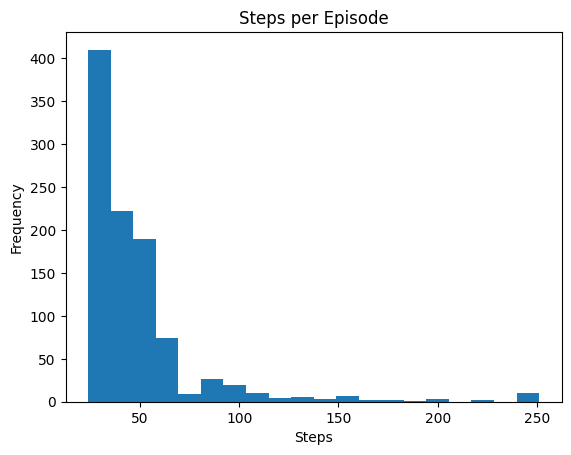

In [7]:
for i in tqdm(range(N)):
    state, _ = env.reset()

    episode = []
    for t in range(500):
        # env.render(mode="human")

        done = False
        action1 = agent.act(state.astype(np.float32), deterministic=True)
        action2 = opponent.act(env.obs_agent_two())

        (next_state, reward, done, trunc, info)  = env.step(np.hstack([action1, action2]))
        episode.append((state, next_state, reward, action1, action2))

        state = next_state

        total_reward += reward

        if done or trunc:
            steps_per_ep.append(t + 1)
            break
    
    if info['winner'] == 1:
        win_count += 1
        episodes.append(episode)

print(f"Average Reward over {N} episodes: {total_reward / N}")
print(f"Win Rate over {N} episodes: {win_count / N}")

plt.hist(steps_per_ep, bins=20)
plt.title("Steps per Episode")
plt.xlabel("Steps")
plt.ylabel("Frequency")
plt.show()

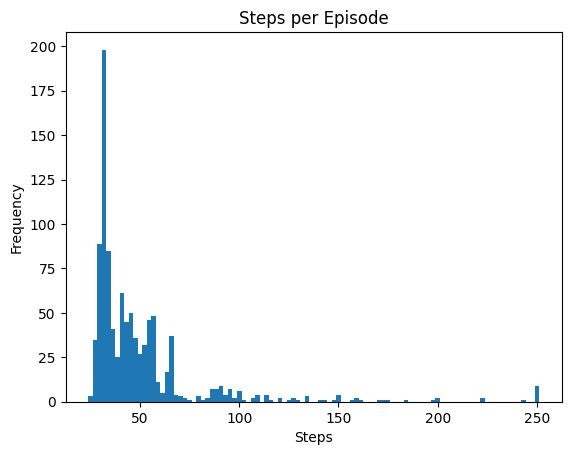

In [8]:
plt.hist(steps_per_ep, bins=100)
plt.title("Steps per Episode")
plt.xlabel("Steps")
plt.ylabel("Frequency")
plt.show()

In [9]:
env.close()

In [12]:
# drop episodes longer than 100
k = 100
trimmed_episodes = []
for transactions in episodes:
    if len(transactions) <= k:
        trimmed_episodes.append(transactions)

In [14]:
k = 50
trimmed_episodes1 = []
for transactions in trimmed_episodes:
    if len(transactions) >= k:
        trimmed_episodes1.append(transactions[-k:])

In [15]:
# only keep state
episodes_states = []
for ep in trimmed_episodes1:
    ep_states = []
    for step in ep:
        ep_states.append(step[0])
    episodes_states.append(ep_states)

x = np.array(episodes_states)
x.shape

(260, 50, 18)

In [16]:
# keep 100 at random

import random
random.seed(42)
selected_episodes = random.sample(episodes_states, 100)

In [19]:
x = np.array(selected_episodes)
x.shape

(100, 50, 18)

In [20]:
# save x
np.save("episodes.npy", x)